# Exploratory Notebook 

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

## Set up

In [217]:
import os
import tqdm
from utils import load_config

import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
import xarray
from rioxarray.exceptions import NoDataInBounds 

from src.utils.data_loader import (
    load_hydro_data, 
    load_station_info,
    load_meteo_data,
    load_water_flows,
    read_soil_data,
    read_altitude_data
)

from src.utils.plots import plot_hydrographic_maps
from src.preprocessing import (
    get_hydro_data,
    aggregate_soil_data
)

import matplotlib.pyplot as plt

### Constants

In [89]:
config = load_config()

In [90]:
RAW_DATA = config['raw_data']
PROCESSED_DATA = config['processed_data']
AREAS = config['areas']
TYPES = config['types']
BBOX = config['bbox']
CRS = config['crs']

### Preprocess hydrological zone data. 
- Understanding the spatial distribution of stations
- Decide aggregation scales for other variables

- [x] load regions
- [ ] spatial join with stations info (inner_join only)
- [ ]  rename to consolidate column names
- [ ]  add function to utils

In [67]:
%%time
brazil_hydro = load_hydro_data('brazil', ROOT)
france_hydro = load_hydro_data('brazil', ROOT)

CPU times: user 26.3 s, sys: 1.01 s, total: 27.3 s
Wall time: 41 s


In [179]:
brazil_stations_train = load_station_info('brazil', 'train', RAW_DATA)
brazil_stations_eval = load_station_info('brazil', 'eval', RAW_DATA)
france_stations_train = load_station_info('france', 'train', RAW_DATA)
france_stations_eval = load_station_info('france', 'eval', RAW_DATA)

Text(0.5, 1.0, 'France Zones and Stations')

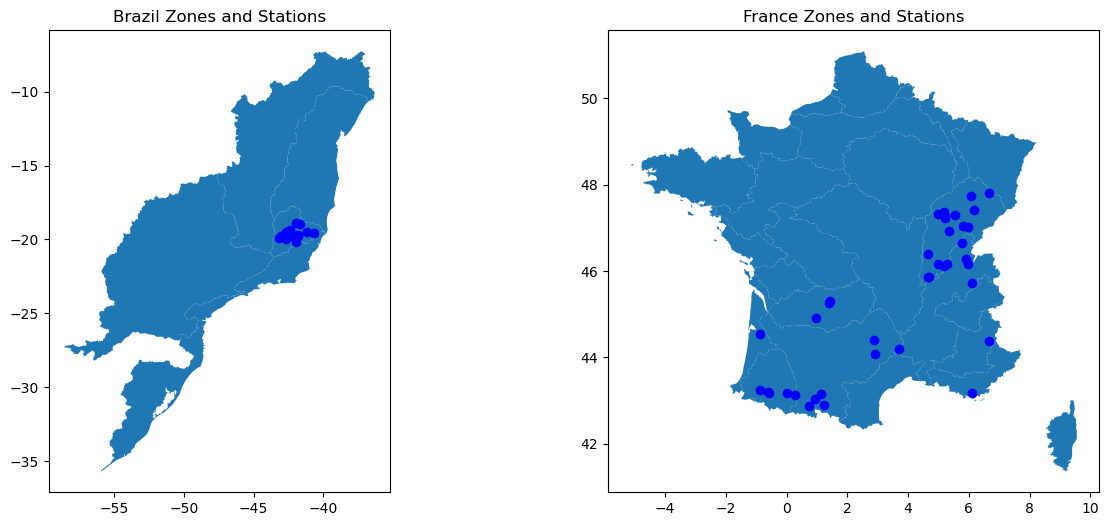

In [180]:
fig, ax = plt.subplots(1, 2, figsize = (15, 6))
brazil_hydro['region'].plot(ax = ax[0])
france_hydro['region'].plot(ax = ax[1])
ax[0].set_title('Brazil Zones and Stations')

brazil_stations_eval.plot(ax = ax[0], color = 'blue')
france_stations_eval.plot(ax = ax[1], color = 'blue')
ax[1].set_title('France Zones and Stations')

### Water flow

In [233]:
brazil_water_flow_train = load_water_flows('brazil', 'train', RAW_DATA)
brazil_water_flow_eval = load_water_flows('brazil', 'eval', RAW_DATA)

In [234]:
brazil_water_flow_train.shape, brazil_water_flow_eval.shape

((6579, 3), (1352, 3))

In [255]:
brazil_water_flow_eval.head()

,station_code,ObsDate,discharge
0,56425000,2004-01-04,251.959325
1,56425000,2004-01-11,348.068529
2,56425000,2004-01-18,566.969486
3,56425000,2004-01-25,431.364643
4,56425000,2004-03-28,267.894943


### Soil Data

In [181]:
brazil_soil_data = read_soil_data('brazil', RAW_DATA)
france_soil_data = read_soil_data('france', RAW_DATA)

In [182]:
n = 6
u = list(brazil_soil_data.data_vars)[n]
v = list(france_soil_data.data_vars)[n]

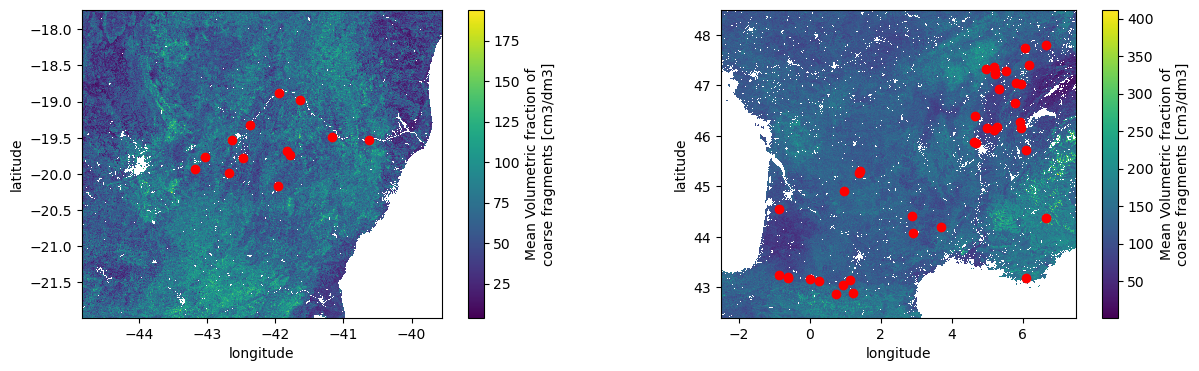

In [183]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
brazil_soil_data[u].plot(ax = ax[0])
stations['brazil'].plot(ax = ax[0], color = 'r');

france_soil_data[v].plot(ax = ax[1])
stations['france'].plot(ax = ax[1], color = 'r');

### Weather Data

- temperature
- precipitation
- soil moisture
- evaporation

Weather data has two more dates than the water flows dataset and needs to be address so aggregation is seamless for the train and eval sets.

In [205]:
brazil_meteo_train = load_meteo_data('brazil', 'train', RAW_DATA)
brazil_meteo_eval = load_meteo_data('brazil', 'eval', RAW_DATA)

In [318]:
brazil_meteo_eval.keys()

dict_keys(['precipitations', 'temperatures', 'soil_moisture', 'evaporation'])

In [326]:
brazil_meteo_eval['temperatures']

<xarray.Dataset> Size: 210kB
Dimensions:     (valid_time: 132, latitude: 18, longitude: 22)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 1kB 2004-01-04 ... 2010-01-03
  * longitude   (longitude) float64 176B -44.84 -44.59 -44.34 ... -39.84 -39.59
  * latitude    (latitude) float64 144B -17.74 -17.99 -18.24 ... -21.74 -21.99
    number      int32 4B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 209kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-15T21:45 GRIB to CDM+CF via cfgrib-0.9.1...

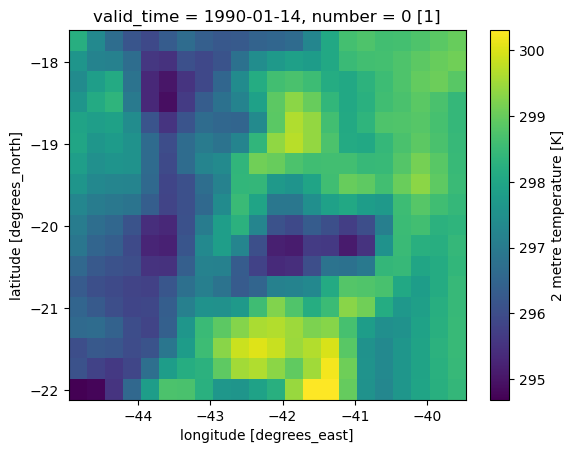

In [331]:
brazil_meteo_train['temperatures']['t2m'][1, :, :].plot()

In [332]:
max_date = brazil_water_flow_eval.ObsDate.max() + pd.Timedelta(7, unit = 'days')
max_date

Timestamp('2009-11-01 00:00:00')

In [352]:
buffer_scales = [50, 100]

weather_df = None

key_vars = {
    'precipitations' : 'tp', 
    'temperatures' : 't2m',
    'soil_moisture' : 'swvl1',
    'evaporation' : 'e'
}
    
for key, var in key_vars.items():
    keys_list = []
    data_var = brazil_meteo_eval[key][var]  # Extract variable
    data_var = data_var.rio.write_crs(CRS)
    for idx, row in brazil_stations_eval.iterrows():
        lat, lon = row.geometry.y, row.geometry.x

        # === 1. Point Sampling ===
        sampled_values = data_var.sel(latitude=lat, longitude=lon, method="nearest").to_dataframe().reset_index()
        # Filter by date range
        sampled_values = sampled_values[sampled_values.valid_time <= max_date]
        sampled_values["station_code"] = row.station_code
        sampled_values = sampled_values[['station_code', 'valid_time', var]]
    
        # === 2. Buffer-based Aggregation ===
        for buffer_size in buffer_scales:
            # Select data within buffer
            buffer_size_deg = buffer_size / 111
            geom = row.geometry.buffer(buffer_size / 111 / 2)
            clipped_data = data_var.rio.clip([geom])
            buffer_values = clipped_data.mean(dim = ['latitude', 'longitude'])
            buffer_values = buffer_values.to_dataframe().reset_index()
            buffer_values = buffer_values[buffer_values.valid_time <= max_date]
            buffer_values['station_code'] = buffer_values["station_code"] = row.station_code
            buffer_values = buffer_values.rename(columns={var: f'{var}_{buffer_size}km'})

            # Merge with point values using date
            sampled_values = sampled_values.merge(
                buffer_values[["valid_time", 'station_code', f'{var}_{buffer_size}km']],
                on=['station_code', "valid_time"],
                how="left"
            )
    
        keys_list.append(sampled_values)

    # Combine all DataFrames
    df_keys = pd.concat(keys_list, ignore_index=True)
    if not isinstance(weather_df, pd.DataFrame):
        weather_df = df_keys
    else:
        weather_df = weather_df.merge(
            df_keys,
            on = ['station_code', "valid_time"],
            how = 'left'
        )
weather_df

,station_code,valid_time,tp,tp_50km,tp_100km,t2m,t2m_50km,t2m_100km,swvl1,swvl1_50km,swvl1_100km,e,e_50km,e_100km
0,56960005,2004-01-04,0.000706,0.000774,0.000763,293.362488,293.958618,294.220795,0.496604,0.496405,0.495490,-0.000106,-0.000113,-0.000112
1,56960005,2004-01-11,0.000363,0.000435,0.000414,294.292694,294.754456,295.052216,0.492507,0.493031,0.492499,-0.000123,-0.000127,-0.000128
2,56960005,2004-01-18,0.000393,0.000464,0.000477,294.974518,295.551025,295.840485,0.494070,0.493718,0.494040,-0.000126,-0.000134,-0.000134
3,56960005,2004-01-25,0.000070,0.000074,0.000071,294.396210,295.019989,295.333374,0.441748,0.442445,0.443167,-0.000156,-0.000160,-0.000160
4,56960005,2004-02-01,0.000082,0.000084,0.000087,295.519623,295.935120,296.248657,0.413392,0.414963,0.415214,-0.000157,-0.000159,-0.000160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685,56696000,2009-10-04,0.000103,0.000094,0.000093,297.116180,296.710449,296.773010,0.419924,0.419678,0.402945,-0.000113,-0.000112,-0.000105
1686,56696000,2009-10-11,0.000143,0.000158,0.000145,296.597626,296.179932,296.243469,0.425526,0.431025,0.416924,-0.000113,-0.000113,-0.000106
1687,56696000,2009-10-18,0.000055,0.000074,0.000069,298.149261,297.699951,297.767029,0.392450,0.404905,0.392166,-0.000130,-0.000135,-0.000127
1688,56696000,2009-10-25,0.000289,0.000336,0.000288,298.313385,297.829193,297.914948,0.447394,0.461790,0.450820,-0.000152,-0.000156,-0.000147


In [334]:
df_final.station_code.nunique(), df_final.groupby('station_code').station_code.count(), brazil_water_flow_eval.groupby('station_code').station_code.count()

(13,
 station_code
 56425000    520
 56539000    520
 56610000    520
 56659998    520
 56696000    520
 56719998    520
 56850000    520
 56920000    520
 56960005    520
 56976000    520
 56978000    520
 56990000    520
 56994500    520
 Name: station_code, dtype: int64,
 station_code
 56425000    104
 56539000    104
 56610000    104
 56659998    104
 56696000    104
 56719998    104
 56850000    104
 56920000    104
 56960005    104
 56976000    104
 56978000    104
 56990000    104
 56994500    104
 Name: station_code, dtype: int64)

In [335]:
df_final.groupby('station_code').date.max(), brazil_water_flow_eval.groupby('station_code').ObsDate.max()

(station_code
 56425000   2009-11-01
 56539000   2009-11-01
 56610000   2009-11-01
 56659998   2009-11-01
 56696000   2009-11-01
 56719998   2009-11-01
 56850000   2009-11-01
 56920000   2009-11-01
 56960005   2009-11-01
 56976000   2009-11-01
 56978000   2009-11-01
 56990000   2009-11-01
 56994500   2009-11-01
 Name: date, dtype: datetime64[ns],
 station_code
 56425000   2009-10-25
 56539000   2009-10-25
 56610000   2009-10-25
 56659998   2009-10-25
 56696000   2009-10-25
 56719998   2009-10-25
 56850000   2009-10-25
 56920000   2009-10-25
 56960005   2009-10-25
 56976000   2009-10-25
 56978000   2009-10-25
 56990000   2009-10-25
 56994500   2009-10-25
 Name: ObsDate, dtype: datetime64[ns])

In [336]:
df_final.head(10)

,station_code,date,tp,tp_50km,tp_100km,t2m,t2m_50km,t2m_100km,swvl1,swvl1_50km,swvl1_100km,e,e_50km,e_100km
0,56960005,2004-01-04,0.000706,0.000774,0.000763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,56960005,2004-01-11,0.000363,0.000435,0.000414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,56960005,2004-01-18,0.000393,0.000464,0.000477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,56960005,2004-01-25,0.000070,0.000074,0.000071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,56960005,2004-02-01,0.000082,0.000084,0.000087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,56960005,2004-03-28,0.000264,0.000318,0.000304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,56960005,2004-04-04,0.000112,0.000124,0.000122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,56960005,2004-04-11,0.000303,0.000390,0.000385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,56960005,2004-04-18,0.000221,0.000242,0.000243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,56960005,2004-04-25,0.000019,0.000020,0.000024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocess data

#### Get hydro stations
The get_hydro_data:
- Loads hydro data
- Loads stations data
- Filters hydro data to include only region, sector, sub_sector or zone the stations fall within
- Adds ids for region, sector, sub_sector and zone for each station to the stations_gdf
- returns the stations_gdf and hydro_gdf

In [73]:
hydro_data = {}
stations = {}

In [74]:
%%time
for area in AREAS:
    stations[area], hydro_data[area] = get_hydro_data(area, RAW_DATA)

CPU times: user 26.6 s, sys: 838 ms, total: 27.5 s
Wall time: 39.8 s


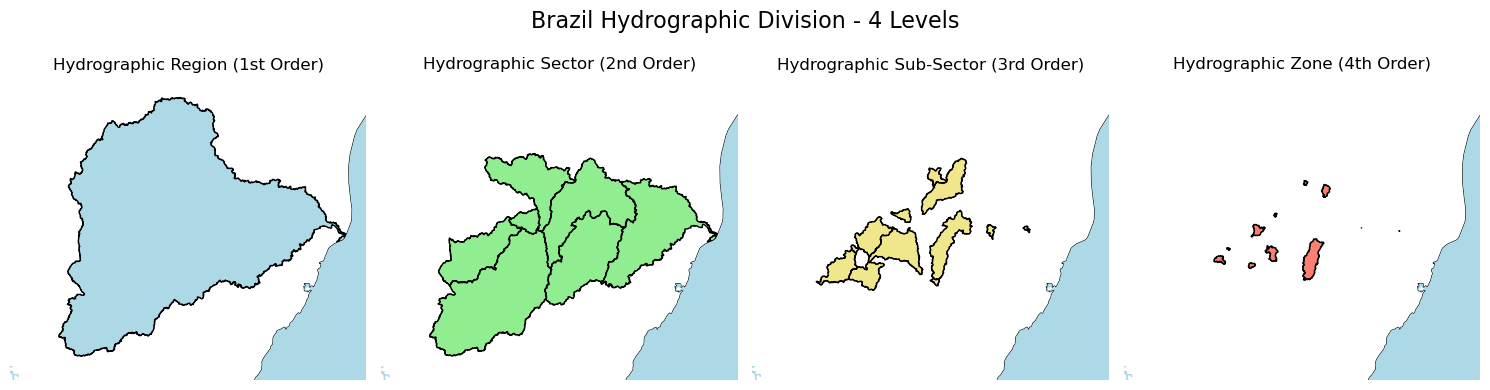

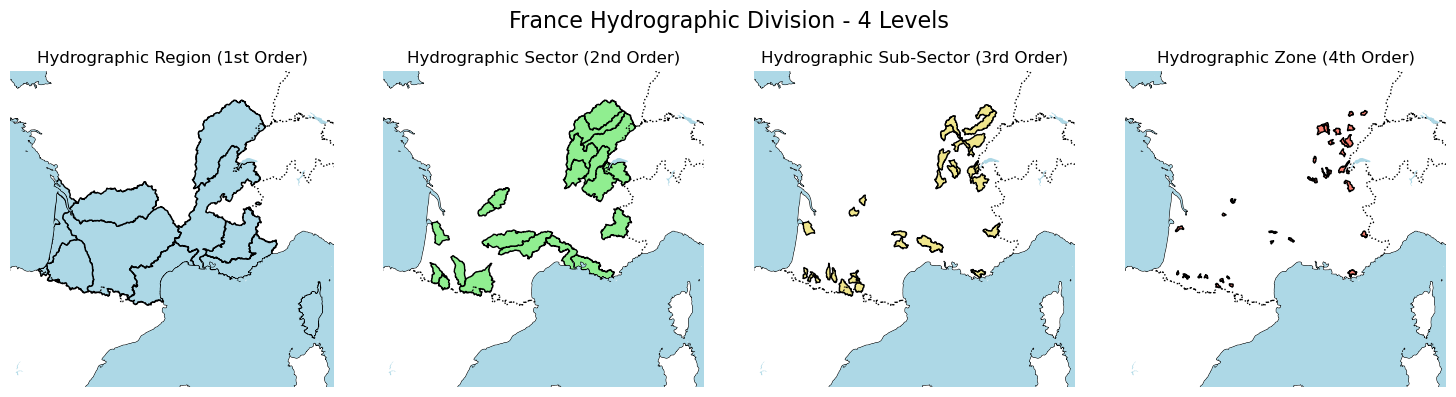

In [93]:
for area in AREAS:
    plot_hydrographic_maps(area, hydro_data, BBOX)

### Load soil data
Sample data at three different scales
- 1km (Local Scale) – Represents the immediate riverbank and riparian zone, capturing soil infiltration, erosion, and vegetation effects on discharge.

- 5km (Field Scale) – Covers the surrounding area that directly contributes surface runoff and subsurface flow, useful for analyzing land use impacts and hillslope hydrology.

- 25km Watershed Scale (Upstream Contributing Area) – The total upstream area draining to the station, ensuring all relevant hydrological influences are included.

In [197]:
%%time
for area in AREAS:
    stations[area] = aggregate_soil_data(area, RAW_DATA, stations[area], buffer_scales = None)

Processing soil data for brazil


  0%|                                                                                  | 0/13 [00:00<?, ?it/s]/home/dakinniyi/miniconda3/envs/zindi_geoai/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/dakinniyi/miniconda3/envs/zindi_geoai/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/dakinniyi/miniconda3/envs/zindi_geoai/lib/python3.12

Processing soil data for france


  0%|                                                                                  | 0/39 [00:00<?, ?it/s]/home/dakinniyi/miniconda3/envs/zindi_geoai/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/dakinniyi/miniconda3/envs/zindi_geoai/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/dakinniyi/miniconda3/envs/zindi_geoai/lib/python3.12

CPU times: user 3min 20s, sys: 1min 6s, total: 4min 27s
Wall time: 6min 13s


### Load Meteorological data